In [1]:
import pandas as pd
from tqdm import tqdm
import obspy
import numpy as np
from obspy.core.utcdatetime import UTCDateTime
import sys
import h5py 
sys.path.append("/home/niyiyu/Research/pnwstore/")

import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.catalog import QuakeClient
from pnwstore.station import StationClient

from collections import Counter

In [2]:
quakeclient = QuakeClient("cascadia", "pnwstore")
stationclient = StationClient("cascadia", "pnwstore")
pd.set_option('display.max_columns', None)

## metadata to be added
- station location:
       latitude, longitude, elevation
- trace_P/S_polarity
    - added in mpi_extract_pnwml.py
- trace_[P/S]_onset
    - added in mpi_extract_pnwml.py
    
- trace_SNR
- trace_uncertainty

- source_magnitude_type
    - added in mpi_extract_pnwml.py
- source_magnitude_uncertainty
    - added in mpi_extract_pnwml.py
- source_horizontal_uncertainty
    - added in mpi_extract_pnwml.py

In [5]:
df = pd.read_csv("/data/whd01/yiyu_data/PNWML/extract/exotic_metadata.csv")
df

,event_id,source_type,station_network_code,trace_channel,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
0,pnsn3179328,probable explosion,UW,EH,GPW,01,48.1179,-121.138,2354.0,"bucket11$0,:3,:18001",100,2021-12-21T22:14:12.000000Z,NaN,NaN,7000.0,emergent,nan|nan|20.812
1,pnsn3179268,probable explosion,UW,HH,RPW2,--,48.4449,-121.526,683.0,"bucket11$1,:3,:18001",100,2021-12-20T22:17:29.000000Z,NaN,NaN,7000.0,emergent,-6.148|6.278|0.882
2,pnsn3179118,probable explosion,CN,HH,PNT,--,49.3224,-119.625,531.0,"bucket11$2,:3,:18001",100,2021-12-18T22:04:54.000000Z,7900.0,impulsive,7000.0,impulsive,6.780|3.425|0.891
3,pnsn3178958,probable explosion,CN,HH,HOPB,--,49.3872,-121.421,236.0,"bucket11$3,:3,:18001",100,2021-12-16T22:05:34.000000Z,NaN,NaN,7000.0,emergent,1.168|-4.904|2.049
4,pnsn3178893,probable explosion,UW,EH,PRO,--,46.2125,-119.687,553.0,"bucket11$4,:3,:18001",100,2021-12-16T19:34:21.000000Z,NaN,NaN,7000.0,emergent,nan|nan|23.791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86067,pnsn830593,surface event,UW,EH,EDM,--,46.1972,-122.151,1609.0,"bucket19$8993,:3,:18001",100,2002-01-02T17:38:01.000000Z,NaN,NaN,7000.0,impulsive,nan|nan|-1.162
86068,pnsn830593,surface event,UW,EH,YEL,--,46.2095,-122.189,1750.0,"bucket19$8994,:3,:18001",100,2002-01-02T17:37:59.000000Z,NaN,NaN,7000.0,impulsive,nan|nan|14.469
86069,pnsn830593,surface event,UW,EH,SEP,--,46.2002,-122.191,2116.0,"bucket19$8995,:3,:18001",100,2002-01-02T17:37:59.000000Z,NaN,NaN,7000.0,impulsive,nan|nan|4.575
86070,pnsn829903,surface event,UW,EH,YEL,--,46.2095,-122.189,1750.0,"bucket19$8996,:3,:18001",100,2002-01-01T21:34:30.000000Z,NaN,NaN,7000.0,impulsive,nan|nan|12.728


In [8]:
df = df.drop(columns = 'splits')

## check location 

In [13]:
df['station_location_code'].unique()

array(['01', '--', '00', '20'], dtype=object)

In [16]:
df[df['station_code'] == 'PR00']

,event_id,source_type,station_network_code,trace_channel,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db


In [22]:
df.iloc[df[pd.isna(df['station_location_code'])].index, 5] = '--'
df.iloc[df[df['station_location_code'] == 0.0].index, 5] = "00"
df.iloc[df[df['station_location_code'] == '1.0'].index, 5] = "01"
df.iloc[df[df['station_location_code'] == 20.].index, 5] = "20"

In [23]:
df.to_csv("../product/exotic_metadata.csv", sep = ',', index=False)

## -999999 to nan

In [12]:
for idx, i in df.iterrows():
    if i['trace_S_arrival_sample'] == -999999:
        df.iloc[idx, 12] = np.nan
    if i['trace_P_arrival_sample'] == -999999:
        df.iloc[idx, 14] = np.nan

In [13]:
df.to_csv("../product/exotic_metadata.csv", sep = ',', index=False)

## add lat lon elevation

In [25]:
error = []
for idx, i in tqdm(df.iterrows(), total = len(df)):
    if pd.isna(i['station_latitude_deg']):
        net = df.iloc[idx, 2]
        sta = df.iloc[idx, 4]
        cha = df.iloc[idx, 3] + "Z"
        time = UTCDateTime(df.iloc[idx, 11])
        loc = df.iloc[idx, 5]
            
        result = stationclient.query(network = net, station = sta, location = loc,
                                     channel = cha, time = time)
        
        try:
            assert len(result) >= 1
            df.iloc[idx, 6] = result.iloc[0, 5]         # latitude
            df.iloc[idx, 7] = result.iloc[0, 6]         # longitude
            df.iloc[idx, 8] = result.iloc[0, 7]         # elevation
            
        except:
            print(idx)
            error.append([idx, i])
#         break

100%|██████████| 86484/86484 [00:47<00:00, 1817.76it/s]


In [26]:
df.to_csv("../product/exotic_metadata.csv", sep = ',', index=False)

## calculate SNR

In [52]:
def cal_snr(data, idp, idn, percentile = 98, string = False):
    snrs = []
    for icha in range(3):
        snrs.append(20 * np.log(np.percentile(np.abs(data[icha, idp-100:idp + 200]), percentile)/
              np.percentile(np.abs(data[icha, idn-800:idn]), percentile))/np.log(10))
    if string:
        return "%.3f|%.3f|%.3f" % (snrs[0], snrs[1], snrs[2])
    else:
        return snrs

In [57]:
df = pd.read_csv("/home/niyiyu/Research/PNW-ML/product/exotic_metadata.csv")

In [79]:
f = h5py.File(f"/home/niyiyu/Research/PNW-ML/product/exotic_waveforms.hdf5", "r")
snrs = []
for idx in tqdm(range(len(df))):
    ids = df.iloc[idx]['trace_S_arrival_sample']
    idp = df.iloc[idx]['trace_P_arrival_sample']
    tn = df.iloc[idx]['trace_name']
    bucket, narray = tn.split('$')
    x, y, z = iter([int(i) for i in narray.split(',:')])
    data = f['/data/%s' % bucket][x, :y, :z]
    data = (data.T - np.mean(data, axis = 1)).T
    if not pd.isna(ids):
        idp = ids
    df.iloc[idx, 16] = cal_snr(data, idp = int(idp), idn = 3000, string = True)
#     for s in cal_snr(data, string = False):
#         if not np.isnan(float(s)):
#             snrs.append(float(s))
f.close()

  0%|          | 0/86484 [00:00<?, ?it/s]/tmp/ipykernel_2691972/48626121.py:4: RuntimeWarning: invalid value encountered in double_scalars
  snrs.append(20 * np.log(np.percentile(np.abs(data[icha, idp-100:idp + 200]), percentile)/
100%|██████████| 86484/86484 [01:52<00:00, 769.22it/s]


In [80]:
snrs = []
for idx, i in df.iterrows():
    for s in i['trace_snr_db'].split('|'):
        if s != 'nan':
            snrs.append(float(s))

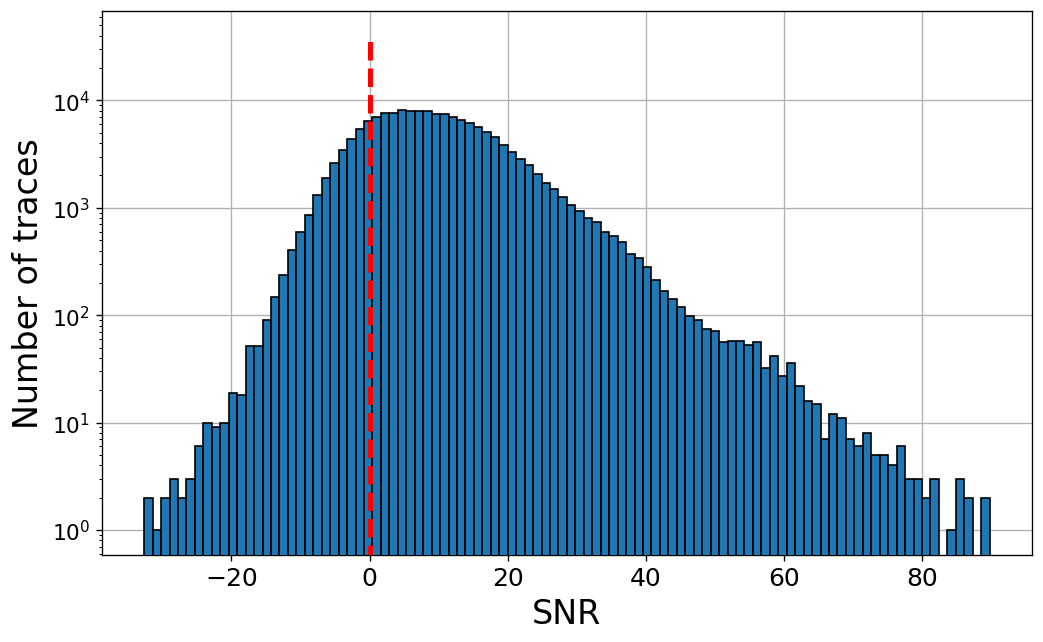

In [81]:
plt.figure(figsize = (10, 6), dpi = 120)
plt.hist(snrs, 100, zorder = 10, edgecolor = 'k')
plt.grid(True)
plt.xticks(np.arange(-40,200, 20), fontsize = 15)
plt.yticks(fontsize = 13)
plt.vlines(0, 0, 4e4, linestyles = '--', linewidth = 3,
           color = 'r', zorder = 11)
plt.xlabel("SNR", fontsize = 20)
plt.ylabel("Number of traces", fontsize = 20)
plt.gca().set_yscale('log')

In [82]:
df.to_csv("/home/niyiyu/Research/PNW-ML/product/exotic_metadata.csv", sep = ',', index=False)

## filter out low SNR

In [50]:
df = pd.read_csv("/home/niyiyu/Research/PNW-ML/data/exotic_metadata.csv")
print(len(df))
for idx, i in df.iterrows():
    snrs = [float(s) for s in i['trace_snr_db'].split('|')]
    for s in snrs:
        if s < -20 or s > 80:
            print("drop!")
            df = df.drop(axis = 0, index = idx)
            break
df = df.reset_index(drop = True)
print(len(df))
df.to_csv("/home/niyiyu/Research/PNW-ML/product/exotic_metadata.csv", sep = ',', index=False)

85936
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
drop!
85910


## shift p/s sample

In [38]:
df = pd.read_csv("../product//exotic_metadata.csv")

In [54]:
for idx, i in df.iterrows():
    df.iloc[idx, 12] += 5000
    df.iloc[idx, 14] += 5000

In [55]:
df

,event_id,event_type,station_network_code,trace_channel,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_S_onset,trace_P_arrival_sample,trace_P_onset,trace_snr_db
0,pnsn3179328,probable explosion,UW,EH,GPW,01,48.1179,-121.138,2354.0,"bucket11$0,:3,:18001",100,2021-12-21T22:14:12.000000Z,NaN,NaN,7000.0,emergent,NaN
1,pnsn3179268,probable explosion,UW,HH,RPW2,--,48.4449,-121.526,683.0,"bucket11$1,:3,:18001",100,2021-12-20T22:17:29.000000Z,NaN,NaN,7000.0,emergent,NaN
2,pnsn3179118,probable explosion,CN,HH,PNT,--,49.3224,-119.625,531.0,"bucket11$2,:3,:18001",100,2021-12-18T22:04:54.000000Z,7900.0,impulsive,7000.0,impulsive,NaN
3,pnsn3178958,probable explosion,CN,HH,HOPB,--,49.3872,-121.421,236.0,"bucket11$3,:3,:18001",100,2021-12-16T22:05:34.000000Z,NaN,NaN,7000.0,emergent,NaN
4,pnsn3178893,probable explosion,UW,EH,PRO,--,46.2125,-119.687,553.0,"bucket11$4,:3,:18001",100,2021-12-16T19:34:21.000000Z,NaN,NaN,7000.0,emergent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86479,pnsn830593,surface event,UW,EH,EDM,--,46.1972,-122.151,1609.0,"bucket19$8993,:3,:18001",100,2002-01-02T17:38:01.000000Z,NaN,NaN,7000.0,impulsive,NaN
86480,pnsn830593,surface event,UW,EH,YEL,--,46.2095,-122.189,1750.0,"bucket19$8994,:3,:18001",100,2002-01-02T17:37:59.000000Z,NaN,NaN,7000.0,impulsive,NaN
86481,pnsn830593,surface event,UW,EH,SEP,--,46.2002,-122.191,2116.0,"bucket19$8995,:3,:18001",100,2002-01-02T17:37:59.000000Z,NaN,NaN,7000.0,impulsive,NaN
86482,pnsn829903,surface event,UW,EH,YEL,--,46.2095,-122.189,1750.0,"bucket19$8996,:3,:18001",100,2002-01-01T21:34:30.000000Z,NaN,NaN,7000.0,impulsive,NaN


In [56]:
df.to_csv("../product//exotic_metadata.csv", sep = ',', index=False)